<a href="https://colab.research.google.com/github/SGhuman123/Data-Science-Portfolio/blob/main/Udemy%20TensorFlow%20Developer%20Certificate%20Bootcamp/Section%207%20Food%20Vision%20Big%20Project/07_1_Milestone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07 Milestone Project 1: 🍔👁 Food Vision Big™

See the annoated version of this notebook on Github: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

In the previous notebook ([transfer learning part 3: scaling up](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb)) we built Food Vision mini: a transfer learning model which beat the original results of the [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) with only 10% of the data.

But you might be wondering, what would happen if we used all the data?

Well, that's what we're going to find out in this notebook!

We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

Yep. All 75,750 training images and 25,250 testing images.

And guess what...

This time **we've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

> 🔑 **Note:** **Top-1 accuracy** means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but top-1 means only the highest one is evaluated). **Top-5 accuracy** means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.

|  | 🍔👁 Food Vision Big™ | 🍔👁 Food Vision mini |
|-----|-----|-----|
| Dataset source | TensorFlow Datasets | Preprocessed download from Kaggle |
| Train data | 75,750 images | 7,575 images |
| Test data | 25,250 images | 25,250 images |
| Mixed precision | Yes | No |
| Data loading | Performanant tf.data API | TensorFlow pre-built function |  
| Target results | 77.4% top-1 accuracy (beat [DeepFood paper](https://arxiv.org/abs/1606.05675)) | 50.76% top-1 accuracy (beat [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)) |

*Table comparing difference between Food Vision Big (this notebook) versus Food Vision mini (previous notebook).*

Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the speed of our model training:
1. Prefetching
2. Mixed precision training

But more on these later.

## What we're going to cover

* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (**making our datasets run fast**)
* Creating modelling callbacks
* Setting up **mixed precision training**
* Building a feature extraction model (see [transfer learning part 1: feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb))
* Fine-tuning the feature extraction model (see [transfer learning part 2: fine-tuning](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb))
* Viewing training results on TensorBoard

### Check GPU

For this notebook, we're going to be doing something different.

We're going to be using mixed precision training.

Mixed precision training was introduced in [TensorFlow 2.4.0](https://blog.tensorflow.org/2020/12/whats-new-in-tensorflow-24.html) (a very new feature at the time of writing).

What does **mixed precision training** do?

Mixed precision training uses a combination of single precision (float32) and half-preicison (float16) data types to speed up model training (up 3x on modern GPUs).

We'll talk about this more later on but in the meantime you can read the [TensorFlow documentation on mixed precision](https://www.tensorflow.org/guide/mixed_precision) for more details.

For now, before we can move forward if we want to use mixed precision training, we need to make sure the GPU powering our Google Colab instance (if you're using Google Colab) is compataible.

For mixed precision training to work, **you need access to a GPU with a compute compability score of 7.0+**.

Google Colab offers free GPUs, however, **not all of them are compatible with mixed precision training**.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here https://developer.nvidia.com/cuda-gpus).

> 🔑 **Note:** You can run the cell below to check your GPU name and then compare it to [list of GPUs on NVIDIA's developer page](https://developer.nvidia.com/cuda-gpus#compute) to see if it's capable of using mixed precision training.

In [ ]:
# If the following line doesn't output "Tesla T4", you can try get access to
# another GPU by going to Runtime -> Factory Reset Runtime -> "Yes" and then
# re-running this cell.
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-9c9f3e98-cd28-8a26-dc92-2906ce76c161)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

Instead of rewriting them (tedious), we'll import the [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) file from the GitHub repo.

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-31 16:17:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-31 16:17:24 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## **Use TensorFlow Datasets to Download Data**

In previous notebooks, we've downloaded our food images (from the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101/home)) from Google Storage.

And this is a typical workflow you'd use if you're working on your own datasets.

However, there's another way to get datasets ready to use with TensorFlow.

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview).

What is **TensorFlow Datasets**?

A place for prepared and ready-to-use machine learning datasets.

Why use TensorFlow Datasets?

* Load data already in Tensors
* Practice on well established datasets
* Experiment with differet data loading techniques (like we're going to use in this notebook)
* Experiment with new TensorFlow features quickly (such as mixed precision training)

Why *not* use TensorFlow Datasets?

* The datasets are static (they don't change, like your real-world datasets would)
* Might not be suited for your particular problem (but great for experimenting)

To begin using TensorFlow Datasets we can import it under the alias `tfds`.

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

To find all of the available datasets in TensorFlow Datasets, you can use the `list_builders()` method.

After doing so, we can check to see if the one we're after (`"food101"`) is present.

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


Beautiful! It looks like the dataset we're after is available (note there are plenty more available but we're on Food101).

To get access to the Food101 dataset from the TFDS, we can use the [`tfds.load()`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method.

In particular, we'll have to pass it a few parameters to let it know what we're after:
* `name` (str) : the target dataset (e.g. `"food101"`)
* `split` (list, optional) : what splits of the dataset we're after (e.g. `["train", "validation"]`)
  * the `split` parameter is quite tricky. See [the documentation for more](https://github.com/tensorflow/datasets/blob/master/docs/splits.md).
* `shuffle_files` (bool) : whether or not to shuffle the files on download, defaults to `False`
* `as_supervised` (bool) : `True` to download data samples in tuple format (`(data, label)`) or `False` for dictionary format
* `with_info` (bool) : `True` to download dataset metadata (labels, number of samples, etc)

> 🔑 **Note:** Calling the `tfds.load()` method will start to download a target dataset to disk if the `download=True` parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [ ]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteJME2T9/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteJME2T9/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


Wonderful! After a few minutes of downloading, we've now got access to entire Food101 dataset (in tensor format) ready for modelling.

Now let's get a little information from our dataset, starting with the class names.

Getting class names from a TensorFlow Datasets dataset requires downloading the "`dataset_info`" variable (by using the `as_supervised=True` parameter in the `tfds.load()` method, **note:** this will only work for supervised datasets in TFDS).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get the class_names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Exploring the Food101 data from TensorFlow Datasets

Now we've downloaded the Food101 dataset from TensorFlow Datasets, how about we do what any good data explorer should?

In other words, "visualize, visualize, visualize".

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

To do, let's take one sample off the training data (using the [`.take()` method](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)) and explore it.

In [ ]:
# Take one sample of train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

Because we used the `as_supervised=True` parameter in our `tfds.load()` method above, data samples come in the tuple format structure `(data, label)` or in our case `(image_tensor, label)`.

In [ ]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Let's loop through our single training sample and get some info from the `image_tensor` and `label`.

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
  


Because we set the `shuffle_files=True` parameter in our `tfds.load()` method above, running the cell above a few times will give a different result each time.

Checking these you might notice some of the images have different shapes, for example `(512, 342, 3)` and `(512, 512, 3)` (height, width, color_channels).

Let's see what one of the image tensors from TFDS's Food101 dataset looks like.

In [ ]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [ ]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Alright looks like our image tensors have values of between 0 & 255 (standard red, green, blue colour values) and the values are of data type `unit8`.

We might have to preprocess these before passing them to a neural network. But we'll handle this later.

In the meantime, let's see if we can plot an image sample.

### Plot an image from TensorFlow Datasets

We've seen our image tensors in tensor format, now let's really adhere to our motto.

"Visualize, visualize, visualize!"

Let's plot one of the image samples using [`matplotlib.pyplot.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) and set the title to target class name.

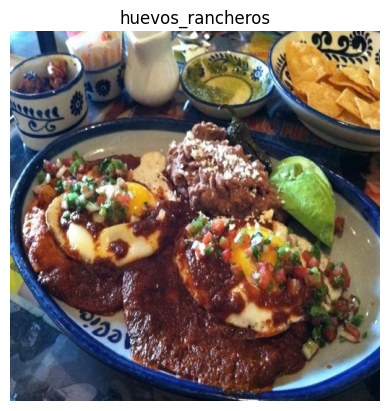

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image to verify the label is associated with the right image
plt.axis(False);

Delicious!

Okay, looks like the Food101 data we've got from TFDS is similar to the datasets we've been using in previous notebooks.

Now let's preprocess it and get it ready for use with a neural network.

## Create preprocessing functions for our data

In previous notebooks, when our images were in folder format we used the method [`tf.keras.utils.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) to load them in.

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc). Doing the above proposed method meant our data was loaded into a format ready to be used with our models.

However, not all data (including data from TensorFlow Dataset) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`)
* Scaled (values between 0 & 1) also called normalized tensors generally performan better.

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `unit8` to `float32`
___
As such, to take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize)
* Converts an input image tensor's current datatype to `tf.float32` using [`tf.cast()`](https://www.tensorflow.org/api_docs/python/tf/cast)

> 🔑 **Note:** Pretrained EfficientNetBX models in [`tf.keras.applications.efficientnet`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet) (what we're going to be using) have rescaling built-in. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "`preprocess_img()`" function (like the one below) or within your model as a [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer.

In [ ]:
# (image, label)

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from `uint8` -> `float32` and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, size=[img_shape, img_shape]) # return target image
  # image = image/255. # scale image values (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

Our `preprocess_img()` function above takes image and label as input (even though it does nothing to the label) because our dataset is currently in the tuple structure `(image, label)`.

Let's try our function out on a target image.

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype})")


Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]..., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>)


Excellent! Looks like our `preprocess_img()` function is working as expected.

The input image gets converted from `uint8` to `float32` and gets reshaped from its current shape to `(224, 224, 3)`.

### Batch & prepare datasets

We're now going to make our data input pipeline run really fast.

Before we can model our data, we have to turn it into batches.

Why?

Because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the [`tf.data` API](https://www.tensorflow.org/api_docs/python/tf/data).

> 📖 **Resource:** For loading data in the most performant way possible, see the TensorFlow docuemntation on [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance).

Specifically, we're going to be using:

* [`map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) - maps a predefined function to a target dataset (e.g. `preprocess_img()` to our image tensors)
* [`shuffle()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) - randomly shuffles the elements of a target dataset up `buffer_size` (ideally, the `buffer_size` is equal to the size of the dataset, however, this may have implications on memory)
* [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) - turns elements of a target dataset into batches (size defined by parameter `batch_size`)
* [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* Extra: [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)

Things to note:
- Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our `preprocess_img()` function)
- `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
- For methods with the `num_parallel_calls` parameter available (such as `map()`), setting it to`num_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
- Can't use `cache()` unless your dataset can fit in memory

Woah, the above is alot. But once we've coded below, it'll start to make sense.

We're going to through things in the following order:

```
Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset
```

This is like saying,

> "Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-prefetching-from-hands-on-ml.png)

*What happens when you use prefetching (faster) versus what happens when you don't use prefetching (slower). **Source:** Page 422 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).*


In [ ]:
# Map preprocssing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
tf.data

<module 'tensorflow._api.v2.data' from '/usr/local/lib/python3.10/dist-packages/tensorflow/_api/v2/data/__init__.py'>

And now let's check out what our prepared datasets look like.

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "*Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a numer of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch.*"

Excellent! Looks like our data is now in tutples of `(image, label)` with datatypes of `(tf.float32, tf.int64)`, just what our model is after.

> 🔑 **Note:** You can get away without calling the `prefetch()` method on the end of your datasets, however, you'd probably see significantly slower data loading speeds when building a model. So most of your dataset input pipelines should end with a call to [`prefecth()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch).

Onward.

## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction


More specifically for each of these callbacks:
* [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - allows us to keep track of our model's training history so we can inspect it later (**note:** we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* [`tf.keras.callbacks.ModelCheckpoint()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
  * Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [ ]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                               monitor='val_accuracy',
                                                               save_best_only=True,
                                                               save_weights_only=True,
                                                               verbose=0) # don't print whether of not model is being saved

## Setup mixed precision

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision:
https://www.tensorflow.org/guide/mixed_precision
___
> *Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.*
___
We touched on mixed precision training above.

However, we didn't quite explain it.

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

In computer science, float32 is also known as [single-precision floating-point format](https://en.wikipedia.org/wiki/Single-precision_floating-point_format). The 32 means it usually occupies 32 bits in computer memory.

Your GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

> **Mixed precision** training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

Can you guess what float16 means?

Well, if you thought since float32 meant single-precision floating-point, you might've guessed float16 means [half-precision floating-point format](https://en.wikipedia.org/wiki/Half-precision_floating-point_format). And if you did, you're right! And if not, no trouble, now you know.

For tensors in float16 format, each element occupies 16 bits in computer memory.

So, where does this leave us?

As mentioned before, when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.

For a more detailed explanation, I encourage you to read through the [TensorFlow mixed precision guide](https://www.tensorflow.org/guide/mixed_precision) (I'd highly recommend at least checking out the summary).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-speedup-equals-3x-gpu.png)
*Because mixed precision training uses a combination of float32 and float16 data types, you may see up to a 3x speedup on modern GPUs.*

> 🔑 **Note:** If your GPU doesn't have a score of over 7.0+ (e.g. P100 in Google Colab), mixed precision won't work (see: ["Supported Hardware"](https://www.tensorflow.org/guide/mixed_precision#supported_hardware) in the mixed precision guide for more).

> 📖 **Resource:** If you'd like to learn more about precision in computer science (the detail to which a numerical quantity is expressed by a computer), see the [Wikipedia page](https://en.wikipedia.org/wiki/Precision_(computer_science)) (and accompanying resources).

Okay, enough talk, let's see how we can turn on mixed precision training in TensorFlow.

The beautiful thing is, the [`tensorflow.keras.mixed_precision`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/) API has made it very easy for us to get started.

First, we'll import the API and then use the [`set_global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/set_global_policy) method to set the *dtype policy* to `"mixed_float16"`.


In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision

In [ ]:
!nvidia-smi

Sun Dec 31 16:31:19 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              40W / 300W |    310MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Nice! As long as the GPU you're using has a compute capability of 7.0+ the cell above should run without error.

Now we can check the global dtype policy (the policy which will be used by layers in our model) using the [`mixed_precision.global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/global_policy) method.

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

Great, since the global dtype policy is now `"mixed_float16"` our model will automatically take advantage of float16 variables where possible and in turn speed up training.

## Build feature extraction model

Callbacks: ready to roll.

Mixed precision: turned on.

Let's build a model.

Because our dataset is quite large, we're going to move towards fine-tuning an existing pretrained model (EfficienetNetB0).

But before we get into fine-tuning, let's set up a feature-extraction model.

Recall, the typical order for using transfer learning is:

1. Build a feature extraction model (replace the top few layers of a pretrained model)
2. Train for a few epochs with lower layers frozen
3. Fine-tune if necessary with multiple layers unfrozen

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-feature-extraction-then-fine-tune.png)
*Before fine-tuning, it's best practice to train a feature extraction model with custom top layers.*

To build the feature extraction model (covered in [Transfer Learning in TensorFlow Part 1: Feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb)), we'll:
* Use `EfficientNetB0` from [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) pre-trained on ImageNet as our base model
  * We'll download this without the top layers using `include_top=False` parameter so we can create our own output layers
* Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet
* Put together the input, base model, pooling and output layers in a [Functional model](https://keras.io/guides/functional_api/)
* Compile the Functional model using the Adam optimizer and [sparse categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) as the loss function (since our labels **aren't** one-hot encoded)
* Fit the model for 3 epochs using the TensorBoard and ModelCheckpoint callbacks

> 🔑 **Note:** Since we're using mixed precision training, our model needs a separate output layer with a hard-coded `dtype=float32`, for example, `layers.Activation("softmax", dtype=tf.float32)`. This ensures the outputs of our model are returned back to the float32 data type which is more numerically stable than the float16 datatype (important for loss calculations). See the ["Building the model"](https://www.tensorflow.org/guide/mixed_precision#building_the_model) section in the TensorFlow mixed precision guide for more.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-code-before-and-after.png)
*Turning mixed precision on in TensorFlow with 3 lines of code.*

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x =base_model(inputs, training=False) # make sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use this crossentropy loss function when there are two or more label classes
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [ ]:
len(class_names), label

(101, <tf.Tensor: shape=(), dtype=int64, numpy=56>)

## Checking layer dtype policies (are we using mixed precision?)

Model ready to go!

Before we said the mixed precision API will automatically change our layers' dtype policy's to whatever the global dtype policy is (in our case it's `"mixed_float16"`).

We can check this by iterating through our model's layers and printing layer attributes such as `dtype` and `dtype_policy`.

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name` (str) : a layer's human-readable name, can be defined by the `name` parameter on construction
* `layer.trainable` (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's `trainable` attribute to `False`)
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy` : the data type a layer computes in

> 🔑 **Note:** A layer can have a dtype of `float32` and a dtype policy of `"mixed_float16"` because it stores its variables (weights & biases) in `float32` (more numerically stable), however it computes in `float16` (faster).

We can also check the same details for our model's base model.

In [ ]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]: # check the layers of the base model (layer at index of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

> 🔑 **Note:** The mixed precision API automatically causes layers which can benefit from using the `"mixed_float16"` dtype policy to use it. It also prevents layers which shouldn't use it from using it (e.g. the normalization layer at the start of the base model).

### TODO: Fit the feature extraction model

Now that's one good looking model. Let's fit it to our data shall we?

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

### Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [ ]:
# Fit the feature extraction model for 3 epochs with tensorboard and model checkpoint callbacks
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all data_feature_extract/20231231-163123
Epoch 1/3
2368/2368 [==============================] - 192s 76ms/step - loss: 1.7182 - accuracy: 0.5811 - val_loss: 1.1339 - val_accuracy: 0.6960
Epoch 2/3
2368/2368 [==============================] - 195s 81ms/step - loss: 1.1997 - accuracy: 0.6882 - val_loss: 1.0338 - val_accuracy: 0.7214
Epoch 3/3
2368/2368 [==============================] - 183s 76ms/step - loss: 1.0549 - accuracy: 0.7233 - val_loss: 0.9932 - val_accuracy: 0.7296


Nice, looks like our feature extraction model is performing pretty well. How about we evaluate it on the whole test dataset?



In [ ]:
# Evaluate model on whole test dataset
results_feature_extract = model.evaluate(test_data)
results_feature_extract

790/790 [==============================] - 53s 66ms/step - loss: 1.0020 - accuracy: 0.7267


[1.0019949674606323, 0.7267326712608337]

And since we used the `ModelCheckpoint` callback, we've got a saved version of our model in the `model_checkpoints` directory.

Let's load it in and make sure it performs just as well.

## Off to you...

We've covered a lot of ground so far but sice this is a milestone project, it's time for you to takeover.

More specifically, your challenge is to compete the TEMPLATE version of 07 to obtain a computer vision model (building off the one we've built in this notebook) to beat the DeepFood paper.

In other words, you're going to create Food Vision Bg!!!

You can find the template notebook here:
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/TEMPLATE_07_food_vision_milestone_project_1.ipynb


And if you get stuck, you can refer to the example version (non-template):
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

## TODO: Save the whole model to file

We can also save the whole model using the [`save()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#save) method.

Since our model is quite large, you might want to save it to Google Drive (if you're using Google Colab) so you can load it in for use later.

> 🔑 **Note:** Saving to Google Drive requires mounting Google Drive (go to Files -> Mount Drive).

We can also save it directly to our Google Colab instance.

> 🔑 **Note:** Google Colab storage is ephemeral and your model will delete itself (along with any other saved files) when the Colab session expires.

In [ ]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
model.save("/content/drive/MyDrive/Udemy TensorFlow/food_vision_model")

And again, we can check whether or not our model saved correctly by loading it in and evaluating it.

In [ ]:
# Load model previously saved above
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Udemy TensorFlow/food_vision_model")

Loading a `SavedModel` also retains all of the underlying layers `dtype_policy` (we want them to be `"mixed_float16"`).

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable,layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 55s 66ms/step - loss: 1.0020 - accuracy: 0.7267


[1.0019949674606323, 0.7267326712608337]

In [ ]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables
(loaded_model_results, results_feature_extract)

([1.0019949674606323, 0.7267326712608337],
 [1.0019949674606323, 0.7267326712608337])

That's what we want! Our loaded model performing as it should.

> 🔑 **Note:** We spent a fair bit of time making sure our model saved correctly because training on a lot of data can be time-consuming, so we want to make sure we don't have to continaully train from scratch.

## TODO: Preparing our model's layers for fine-tuning

Our feature-extraction model is showing some great promise after three epochs. But since we've got so much data, it's probably worthwhile that we see what results we can get with fine-tuning (fine-tuning usually works best when you've got quite a large amount of data).

**Goal**: Fine-tune the feature extraction model to beat the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf).

They were able to achieve 77.4% top-1 accuracy on Food101 over 2-3 days of training.

Do you think fine-tuning will get us there?

Let's find out.

To start, let's load in our saved model.

> 🔑 **Note:** It's worth remembering a traditional workflow for fine-tuning is to freeze a pre-trained base model and then train only the output layers for a few iterations so their weights can be updated inline with your custom data (feature extraction). And then unfreeze a number or all of the layers in the base model and continue training until the model stops improving.

Like all good cooking shows, I've saved a model I prepared earlier (the feature extraction model from above) to Google Storage.

You can download it to make sure you're using the same model as originall trained going forward.



In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip


--2023-12-31 16:44:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.172.207, 108.177.112.207, 74.125.124.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.172.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  --.-KB/s    in 0.1s    

2023-12-31 16:44:07 (109 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
# Load and evaluate downloaded GS model
loaded_model_2 = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
# Get a summary of the downloaded model
loaded_model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

And now let's make sure our loaded model is performing as expected.

In [ ]:
# How does the loaded model perform? (evaluate it on the test dataset)
loaded_model_2_results = loaded_model_2.evaluate(test_data)
loaded_model_2_results

790/790 [==============================] - 53s 64ms/step - loss: 1.0881 - accuracy: 0.7065


[1.0880992412567139, 0.7064950466156006]

Great, our loaded model is performing as expected.

When we first created our model, we froze all of the layers in the base model by setting `base_model.trainable=False` but since we've loaded in our model from file, let's check whether or not the layers are trainable or not.

In [ ]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
loaded_model_2.trainable = True
for layer in loaded_model_2.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
pooling_layer True
dense True
softmax_float32 True


Alright, it seems like each layer in our loaded model is trainable. But what if we got a little deeper and inspected each of the layers in our base model?

> 🤔 **Question:** *Which layer in the loaded model is our base model?*

Before saving the Functional model to file, we created it with five layers (layers below are 0-indexed):
0. The input layer
1. The pre-trained base model layer ([`tf.keras.applications.efficientnet.EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0))
2. The pooling layer
3. The fully-connected (dense) layer
4. The output softmax activation (with float32 dtype)

Therefore to inspect our base model layer, we can access the `layers` attribute of the layer at index 1 in our model.

In [ ]:
# Check to see what dtype_policy of the layers in your loaded model are
for layer in loaded_model_2.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype ,layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [ ]:
# loaded_model_2.layers[1].layers

Wonderful, it looks like each layer in our base model is trainable (unfrozen) and every layer which should be using the dtype policy `"mixed_policy16"` is using it.

Since we've got so much data (750 images x 101 training classes = 75750 training images), let's keep all of our base model's layers unfrozen.

> 🔑 **Note:** If you've got a small amount of data (less than 100 images per class), you may want to only unfreeze and fine-tune a small number of layers in the base model at a time. Otherwise, you risk overfitting.

## A couple more callbacks

We're about to start fine-tuning a deep learning model with over 200 layers using over 100,000 (75k+ training, 25K+ testing) images, which means our model's training time is probably going to be much longer than before.

> 🤔 **Question:** *How long does training take?*

It could be a couple of hours or in the case of the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf) (the baseline we're trying to beat), their best performing model took 2-3 days of training time.

You will really only know how long it'll take once you start training.

> 🤔 **Question:** *When do you stop training?*

Ideally, when your model stops improving. But again, due to the nature of deep learning, it can be hard to know when exactly a model will stop improving.

Luckily, there's a solution: the [`EarlyStopping` callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

The `EarlyStopping` callback monitors a specified model performance metric (e.g. `val_loss`) and when it stops improving for a specified number of epochs, automatically stops training.

Using the `EarlyStopping` callback combined with the `ModelCheckpoint` callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

Let's set both of these up to monitor our model's `val_loss`.

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more
EarlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more
checkpoint_path = "loaded_model_2_checkpoint"
ModelCheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                              monitor="val_loss", # save the model weights with best validation loss
                                                              save_best_only=True, # only save the best weights
                                                              )

Woohoo! Fine-tuning callbacks ready.

If you're planning on training large models, the `ModelCheckpoint` and `EarlyStopping` are two callbacks you'll want to become very familiar with.

We're almost ready to start fine-tuning our model but there's one more callback we're going to implement: [`ReduceLROnPlateau`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau).

Remember how the learning rate is the most important model hyperparameter you can tune? (if not, treat this as a reminder).

Well, the `ReduceLROnPlateau` callback helps to tune the learning rate for you.

Like the `ModelCheckpoint` and `EarlyStopping` callbacks, the `ReduceLROnPlateau` callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

> 🤔 **Question:** *Why lower the learning rate?*

Imagine having a coin at the back of the couch and you're trying to grab with your fingers.

Now think of the learning rate as the size of the movements your hand makes towards the coin.

The closer you get, the smaller you want your hand movements to be, otherwise the coin will be lost.

Our model's ideal performance is the equivalent of grabbing the coin. So as training goes on and our model gets closer and closer to it's ideal performance (also called **convergence**), we want the amount it learns to be less and less.

To do this we'll create an instance of the `ReduceLROnPlateau` callback to monitor the validation loss just like the `EarlyStopping` callback.

Once the validation loss stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5 (e.g. `0.001` to `0.0002`).

And to make sure the learning rate doesn't get too low (and potentially result in our model learning nothing), we'll set the minimum learning rate to `1e-7`.

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)
reduce_lr

Learning rate reduction ready to go!

Now before we start training, we've got to recompile our model.

We'll use sparse categorical crossentropy as the loss and since we're fine-tuning, we'll use a 10x lower learning rate than the Adam optimizers default (`1e-4` instead of `1e-3`).

In [ ]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
loaded_model_2.compile(loss="sparse_categorical_crossentropy",
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       metrics=["accuracy"])

In [ ]:
# test_data.take(1), train_data.take(1)

Okay, model compiled.

Now let's fit it on all of the data.

We'll set it up to run for up to 100 epochs.

Since we're going to be using the `EarlyStopping` callback, it might stop before reaching 100 epochs.

> 🔑 **Note:** Running the cell below will set the model up to fine-tune all of the pre-trained weights in the base model on all of the Food101 data. Doing so with **unoptimized** data pipelines and **without** mixed precision training will take a fairly long time per epoch depending on what type of GPU you're using (about 15-20 minutes on Colab GPUs). But don't worry, **the code we've written above will ensure it runs much faster** (more like 4-5 minutes per epoch).

In [ ]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
history_loaded_model_2 = loaded_model_2.fit(train_data,
                                            epochs=100,
                                            steps_per_epoch=len(train_data),
                                            validation_data=test_data,
                                            validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training
                                            callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                   experiment_name="efficientb0_101_classes_all_data_fine_tuning"),
                                                       ModelCheckpoint_callback,
                                                       EarlyStopping_callback,
                                                       reduce_lr])


Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20231231-164515
Epoch 1/100
2368/2368 [==============================] - 375s 137ms/step - loss: 0.9243 - accuracy: 0.7525 - val_loss: 0.7923 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 291s 122ms/step - loss: 0.5670 - accuracy: 0.8434 - val_loss: 0.8464 - val_accuracy: 0.7760 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.3144 - accuracy: 0.9112
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 291s 122ms/step - loss: 0.3144 - accuracy: 0.9112 - val_loss: 0.8960 - val_accuracy: 0.7807 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 295s 124ms/step - loss: 0.0879 - accuracy: 0.9781 - val_loss: 0.9724 - val_accuracy: 0.8040 - lr: 2.0000e-05


> 🔑 **Note:** If you didn't use mixed precision or use techniques such as [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) in the *Batch & prepare datasets* section, your model fine-tuning probably takes up to 2.5-3x longer per epoch (see the output below for an example).

| | Prefetch and mixed precision | No prefetch and no mixed precision |
|-----|-----|-----|
| Time per epoch | ~280-300s | ~1127-1397s |

*Results from fine-tuning 🍔👁 Food Vision Big™ on Food101 dataset using an EfficienetNetB0 backbone using a Google Colab Tesla T4 GPU.*

```
Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20231231-164515
Epoch 1/100
2368/2368 [==============================] - 375s 137ms/step - loss: 0.9243 - accuracy: 0.7525 - val_loss: 0.7923 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 291s 122ms/step - loss: 0.5670 - accuracy: 0.8434 - val_loss: 0.8464 - val_accuracy: 0.7760 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.3144 - accuracy: 0.9112
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 291s 122ms/step - loss: 0.3144 - accuracy: 0.9112 - val_loss: 0.8960 - val_accuracy: 0.7807 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 295s 124ms/step - loss: 0.0879 - accuracy: 0.9781 - val_loss: 0.9724 - val_accuracy: 0.8040 - lr: 2.0000e-05
```
*Example fine-tuning time for non-prefetched data as well as non-mixed precision training (~2.5-3x longer per epoch).*

Let's make sure we save our model before we start evaluating it.

From the above, does it look like our model is overfitting or underfitting?

Remember, if the training loss is significantly lower than the validation loss, it's a hint that the model has overfit the training data and not learned generalizable patterns to unseen data.

But it does look like our model has gained a few performance points from fine-tuning, let's evaluate on the whole test dataset and see if managed to beat the [DeepFood paper's](https://arxiv.org/abs/1606.05675) result of 77.4% accuracy.

In [ ]:
# Save model to Google Drive (optional)
# loaded_model_2.save("/content/drive/MyDrive/Udemy TensorFlow/efficientb0_101_classes_all_data_fine_tuning")

In [ ]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
loaded_model_2.save("efficientb0_101_classes_all_data_fine_tuning")

In [ ]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
results_history_loaded_model_2 = loaded_model_2.evaluate(test_data)
results_history_loaded_model_2

790/790 [==============================] - 53s 66ms/step - loss: 0.9834 - accuracy: 0.7954


[0.9833585023880005, 0.7954455614089966]

## TODO: View training results on TensorBoard

Since we tracked our model's fine-tuning training logs using the `TensorBoard` callback, let's upload them and inspect them on TensorBoard.dev.

> **To do:** Upload and view your model's training results to TensorBoard.dev and view them.

See https://tensorboard.dev/ for more.

In [ ]:
# # YOUR_CODE_HERE
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
#   --name "efficientnetb0_101_classes_all data_feature_extract vs. efficientb0_101_classes_all_data_fine_tuning" \
#   --description "Comparing two different TF Hub feature extraction models using 75% of training images" \
#   --one_shot

#   Uploading TensorBoard logs to https://tensorboard.dev/ is no longer
# supported.

# TensorBoard.dev is shutting down.

# Please export your experiments by Dec 31, 2023.

# See the FAQ at https://tensorboard.dev.


Viewing at our [model's training curves on TensorBoard.dev](https://tensorboard.dev/experiment/2KINdYxgSgW2bUg7dIvevw/), it looks like our fine-tuning model gains boost in performance but starts to overfit as training goes on.

See the training curves on TensorBoard.dev here: https://tensorboard.dev/experiment/2KINdYxgSgW2bUg7dIvevw/

To fix this, in future experiments, we might try things like:
* A different iteration of `EfficientNet` (e.g. `EfficientNetB4` instead of `EfficientNetB0`).
* Unfreezing less layers of the base model and training them rather than unfreezing the whole base model in one go.

In [ ]:
# Check out experiments
# !tensorboard dev list # uncomment to see

In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id [INSERT EXPERIMENT ID]

In [ ]:
# Check to see if experiments still exist
# !tensorboard dev list # uncomment to see

### TODO: Evaluate your trained model
Some ideas you might want to go through:
1. Find the precision, recall and f1 scores for each class (all 101). `DONE`
2. Build a confusion matrix for each of the classes. `DONE`
3. Find your model's most wrong predictions (those with the highest prediction probability but the wrong prediction). `DONE`

See the evaluation section at the end of [Transfer Learning Part 3: Scaling Up for more](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb).

1. Find the precision, recall and f1 scores for each class (all 101).

In [ ]:
# Make predictions with model
preds_probs = loaded_model_2.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 52s 63ms/step


In [ ]:
preds_probs.shape

(25250, 101)

In [ ]:
# What does the first prediction probability array look like?
# preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 29,  81,  91,  53,  97,  36,  10,  31,   3, 100])

In [ ]:
# Get the class_names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
# y_labels = []
# for images, labels in test_data.unbatch():
#   y_labels.append(labels.numpy().argmax()) # currently test labels loo like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs
# y_labels[:10]

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [ ]:
len(y_labels)

25250

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.7954455445544555

In [ ]:
# Precision, recall and F1 scores for each class (all 101)
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.65      0.57      0.61       250
           1       0.71      0.77      0.74       250
           2       0.87      0.87      0.87       250
           3       0.85      0.80      0.83       250
           4       0.71      0.78      0.75       250
           5       0.67      0.69      0.68       250
           6       0.78      0.86      0.82       250
           7       0.86      0.95      0.90       250
           8       0.59      0.66      0.62       250
           9       0.84      0.68      0.75       250
          10       0.80      0.69      0.74       250
          11       0.79      0.84      0.81       250
          12       0.90      0.86      0.88       250
          13       0.80      0.78      0.79       250
          14       0.73      0.80      0.76       250
          15       0.75      0.61      0.67       250
          16       0.58      0.70      0.63       250
          17       0.85    

2. Build a confusion matrix for each of the classes.


In [ ]:
# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print veritcally
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

3. Find your model's most wrong predictions (those with the highest prediction probability but the wrong prediction). - `Try and finish`


In [ ]:
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming y_labels and pred_classes are your ground truth labels and predicted classes
# Calculate overall accuracy
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
print("Overall Accuracy:", sklearn_accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_labels, pred_classes)

# Calculate accuracy for each class
class_accuracies = []
for i in range(conf_matrix.shape[0]):
    correct_predictions = conf_matrix[i, i]
    total_predictions = sum(conf_matrix[i, :])
    accuracy = correct_predictions / total_predictions if total_predictions != 0 else 0
    class_accuracies.append((i, accuracy))

# Sort classes by accuracy in descending order
sorted_classes = sorted(class_accuracies, key=lambda x: x[1], reverse=True)
sorted_classes[:5]

Overall Accuracy: 0.7954455445544555


[(33, 0.984), (7, 0.948), (45, 0.944), (75, 0.936), (69, 0.932)]

In [ ]:
# Print the top 3 classes with the most wrong predictions and their accuracy values
print("Top 3 classes with most wrong predictions:")
for i in range(min(3, len(sorted_classes))):
    class_index, accuracy = sorted_classes[-i-1]
    print(f"Class {class_names[class_index]}: Accuracy = {accuracy}, Correct Predictions = {conf_matrix[class_index, class_index]}, Total Predictions = {sum(conf_matrix[class_index, :])}")

Top 3 classes with most wrong predictions:
Class steak: Accuracy = 0.52, Correct Predictions = 130, Total Predictions = 250
Class chocolate_mousse: Accuracy = 0.548, Correct Predictions = 137, Total Predictions = 250
Class foie_gras: Accuracy = 0.552, Correct Predictions = 138, Total Predictions = 250


## 🛠 Exercises

1. Use the same evaluation techniques on the large-scale Food Vision model as you did in the previous notebook ([Transfer Learning Part 3: Scaling up ](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb)). More specifically, it would be good to see:

    (a) A confusion matrix between all of the model's predictions and true labels.  `DONE`

    (b) A graph showing the f1-scores of each class.  `DONE`

    (c) A visualization of the model making predictions on various images and comparing the predictions to the ground truth. - `DONE`
  
  * For example, plot a sample image from the test dataset and have the title of the plot show the prediction, the prediction probability and the ground truth label.

2. Take 3 of your own photos of food and use the Food Vision model to make predictions on them. How does it go? Share your images/predictions with the other students. - `DONE`
3. Retrain the model (feature extraction and fine-tuning) we trained in this notebook, except this time use EfficientNetB4 as the base model instead of `EfficientNetB0`. Do you notice an improvement in performance? Does it take longer to train? Are there any tradeoffs to consider? - `Try and finish`
4. Name one important benefit of mixed precision training, how does this benefit take place?

### (b) A graph showing the f1-scores of each class.

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
# classification_report_dict

In [ ]:
class_names[70], class_names[98]

('pad_thai', 'tiramisu')

In [ ]:
classification_report_dict["99"]

{'precision': 0.6653225806451613,
 'recall': 0.66,
 'f1-score': 0.6626506024096386,
 'support': 250}

In [ ]:
# Create empty dictionary
class_f1_scores  = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.6068376068376068,
 'baby_back_ribs': 0.7398843930635838,
 'baklava': 0.8685258964143426,
 'beef_carpaccio': 0.8271604938271604,
 'beef_tartare': 0.745697896749522,
 'beet_salad': 0.6824457593688363,
 'beignets': 0.816793893129771,
 'bibimbap': 0.9045801526717557,
 'bread_pudding': 0.6203007518796992,
 'breakfast_burrito': 0.750551876379691,
 'bruschetta': 0.7413793103448275,
 'caesar_salad': 0.8146718146718146,
 'cannoli': 0.8770491803278688,
 'caprese_salad': 0.7886178861788617,
 'carrot_cake': 0.761904761904762,
 'ceviche': 0.6696035242290749,
 'cheesecake': 0.6342342342342342,
 'cheese_plate': 0.8433734939759037,
 'chicken_curry': 0.7178423236514522,
 'chicken_quesadilla': 0.8242677824267783,
 'chicken_wings': 0.853228962818004,
 'chocolate_cake': 0.6996047430830039,
 'chocolate_mousse': 0.6035242290748899,
 'churros': 0.8866396761133603,
 'clam_chowder': 0.8549019607843137,
 'club_sandwich': 0.8353413654618473,
 'crab_cakes': 0.7207920792079208,
 'creme_brulee': 0.8

In [ ]:
# Turn f1-scores into dataframe for visualisations
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

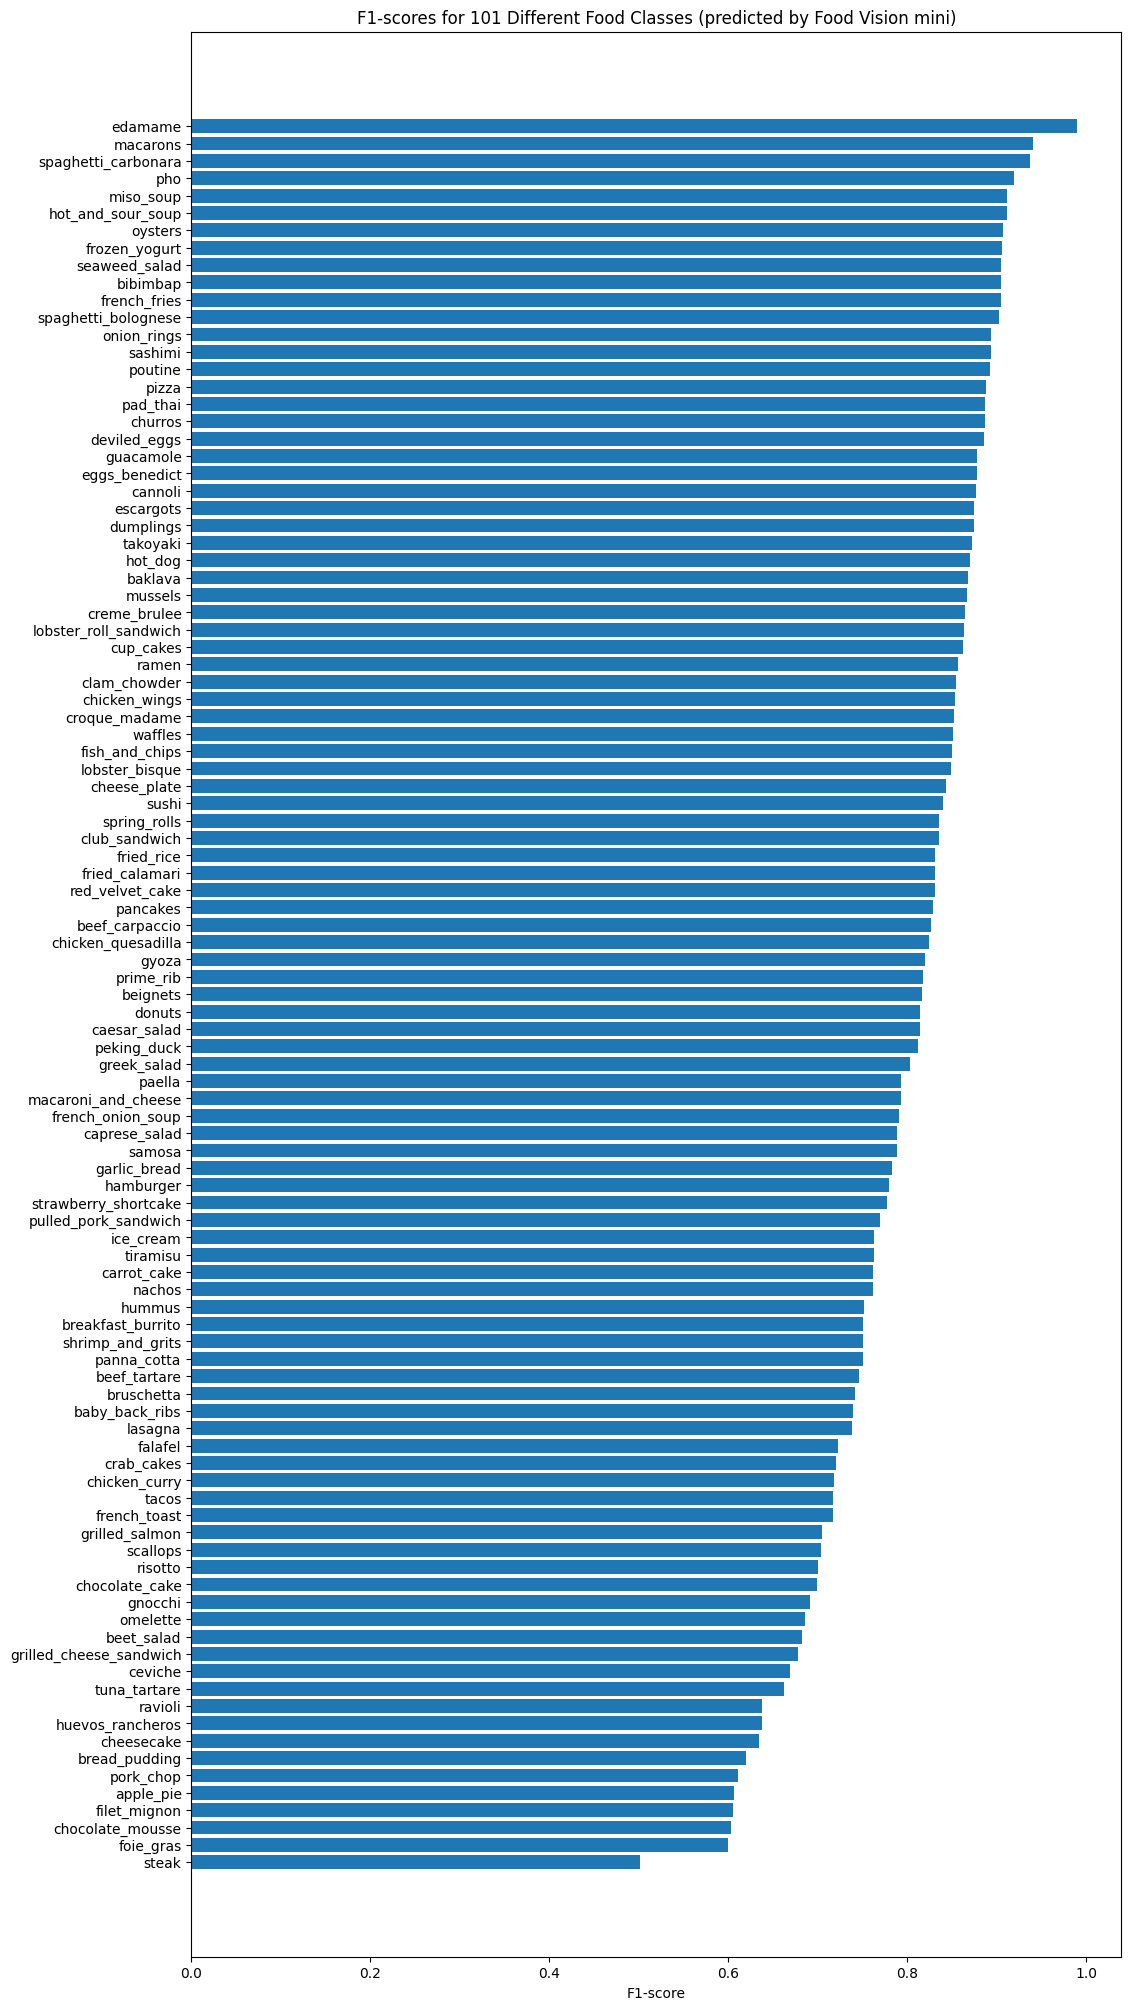

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis(); # reverse the order of our plot

### (c) A visualization of the model making predictions on various images and comparing the predictions to the ground truth.
  * For example, plot a sample image from the test dataset and have the title of the plot show the prediction, the prediction probability and the ground truth label.

In [ ]:
# Take one sample of train data
train_random_3_samples = train_data.unbatch().take(3) # samples are in format (image_tensor, label)

In [ ]:
# What does one sample of our training data look like?
train_random_3_samples

<_TakeDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label=None, img_shape=224):
  """
  Converts image datatype from `uint8` -> `float32` and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, size=[img_shape, img_shape]) # return target image
  # image = image/255. # scale image values (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

1/1 [==============================] - 0s 32ms/step


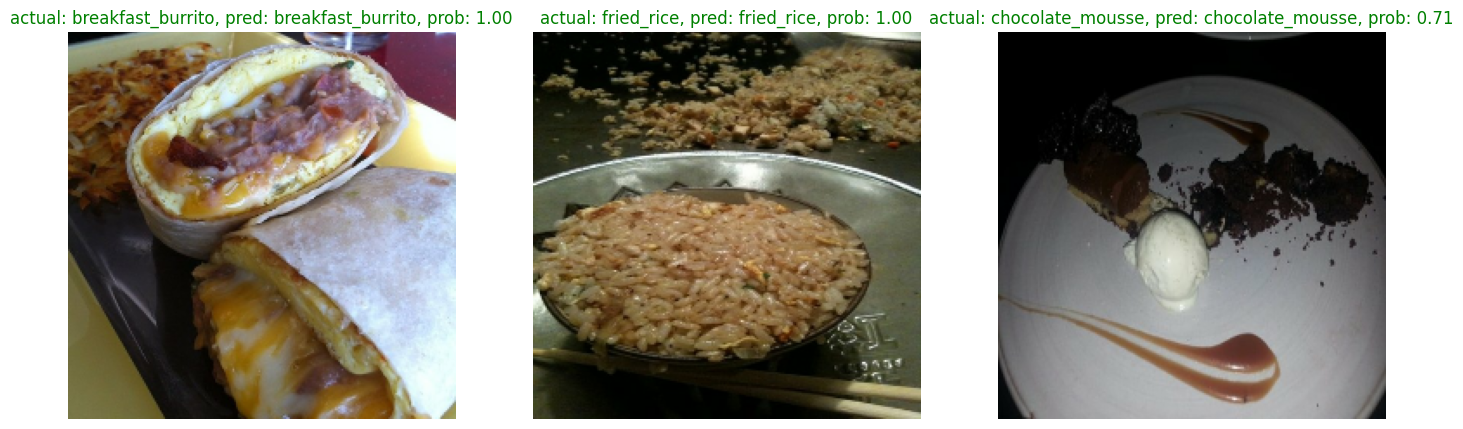

In [ ]:
# Out put info about our training sample
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

i = 0
plt.figure(figsize=(17, 10))
for image, label in train_random_3_samples:

  # Output info about our training sample
  # print(f"""
  # Image shape: {image.shape},
  # Image datatype: {image.dtype},
  # Target class from Food101 (tensor form): {label}
  # Class name (str form): {class_names[label.numpy()]}
  # """)
  class_name = class_names[label.numpy()]

  # What does our image tensor from TFDS's Food101 look like?
  # print(image)

  # What are the min and max values of our image tensor?
  # print(tf.reduce_min(image), tf.reduce_max(image))

  # Load the image and make predictions
  img = preprocess_img(image, label)
  # print(img[0].shape)
  img_expanded = tf.expand_dims(img[0], axis=0)
  # print(img_expanded)
  pred_prob = loaded_model_2.predict(img_expanded) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probabilities index and match it class_name list
  # print(pred_prob)
  # print(pred_class)

  i += 1
  # Plot the image
  plt.subplot(1, 3, i)
  plt.imshow(img[0]/255.)
  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color) # add title to image to verify the label is associated with the right image
  plt.axis(False); # turn off axis


### 2. Take 3 of your own photos of food and use the Food Vision model to make predictions on them. How does it go? Share your images/predictions with the other students.

In [ ]:
# Get custom images
!wget https://github.com/SGhuman123/TensorFlow_HW/blob/main/custom_food_images_2.zip?raw=true
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

unzip_data("custom_food_images_2.zip?raw=true")

--2023-12-31 17:12:52--  https://github.com/SGhuman123/TensorFlow_HW/blob/main/custom_food_images_2.zip?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/SGhuman123/TensorFlow_HW/raw/main/custom_food_images_2.zip [following]
--2023-12-31 17:12:53--  https://github.com/SGhuman123/TensorFlow_HW/raw/main/custom_food_images_2.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SGhuman123/TensorFlow_HW/main/custom_food_images_2.zip [following]
--2023-12-31 17:12:53--  https://raw.githubusercontent.com/SGhuman123/TensorFlow_HW/main/custom_food_images_2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|18

In [ ]:
import os

# Get the custom food images filepaths
custom_food_images = ["custom_food_images_2/" + img_path for img_path in os.listdir("custom_food_images_2")]
custom_food_images

['custom_food_images_2/foodie-flavours-d8R6skOYHUU-unsplash.jpg',
 'custom_food_images_2/rosalie-barley-qb8EK1uQF9w-unsplash.jpg',
 'custom_food_images_2/amanda-lim-YBjYWV2UUj0-unsplash.jpg',
 'custom_food_images_2/aliona-gumeniuk-_wdXUGB2GO4-unsplash.jpg',
 'custom_food_images_2/katie-musial-TbgRGRSwlNo-unsplash.jpg',
 'custom_food_images_2/kevin-lanceplaine-WxxCFDHFeLc-unsplash.jpg',
 'custom_food_images_2/esperanza-doronila-4FO9vox0T7M-unsplash.jpg',
 'custom_food_images_2/amirali-mirhashemian-JqG9YJWy6eI-unsplash.jpg',
 'custom_food_images_2/keesha-s-kitchen-fdjsZkEN-t0-unsplash.jpg',
 'custom_food_images_2/mai-qu-c-tung-lam-HyuvFrHlJZc-unsplash.jpg']

1/1 [==============================] - 0s 31ms/step


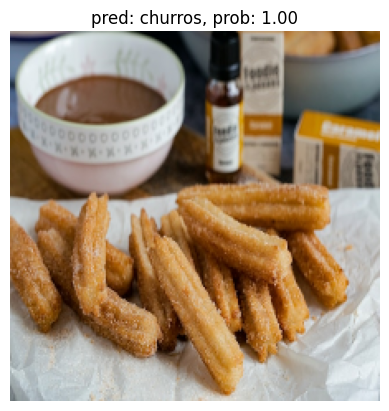

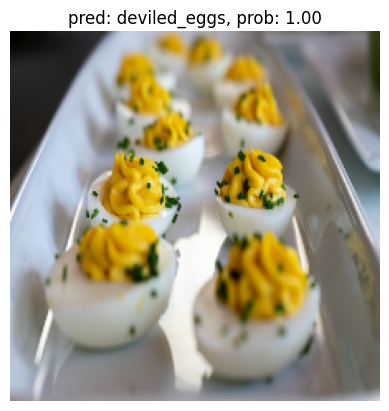

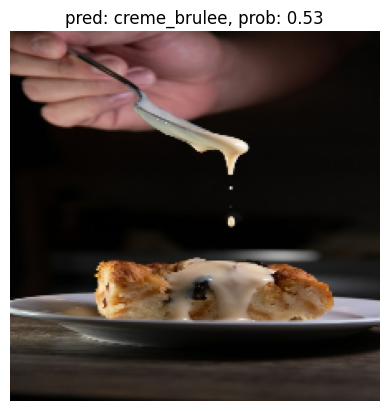

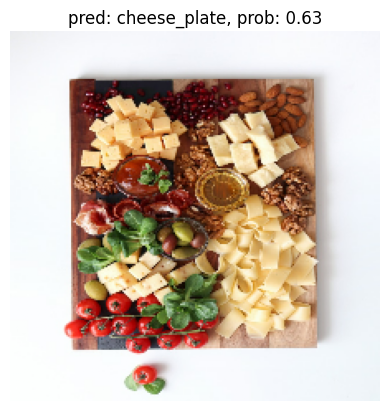

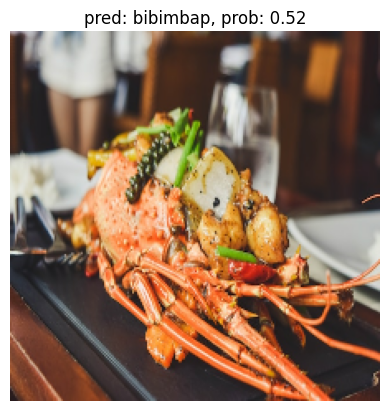

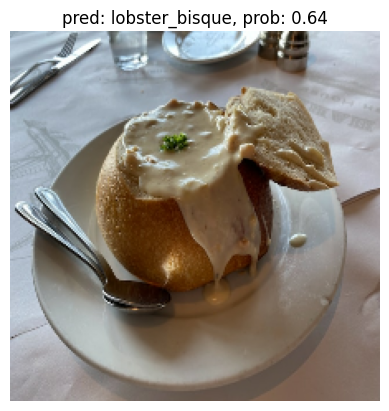

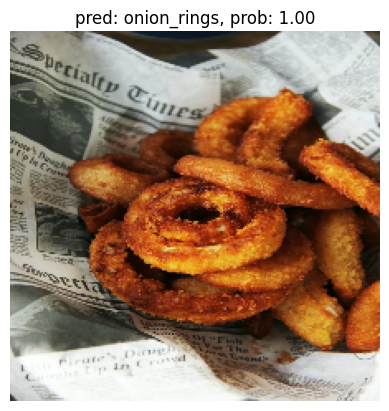

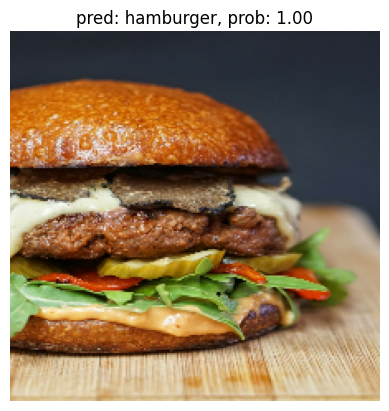

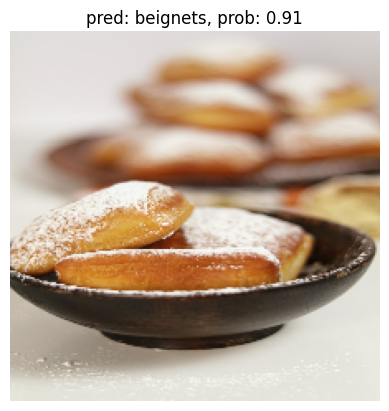

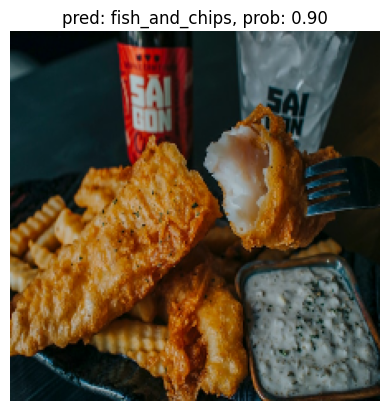

In [ ]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img = tf.io.read_file(img) # read image file
  img = tf.image.decode_jpeg(img, channels=3) # decode image into tensor
  img = tf.image.resize(img, size=[224, 224]) # resize image
  img = preprocess_img(img)[0] # don't need to scale for our EfficientNetB0 model
  pred_prob = loaded_model_2.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index with the highest prediction probability
  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

### 3. Retrain the model (feature extraction and fine-tuning) we trained in this notebook, except this time use `EfficientNetB4` as the base model instead of `EfficientNetB0`. Do you notice an improvement in performance? Does it take longer to train? Are there any tradeoffs to consider? - `Try and finish`

### Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model_B4 = tf.keras.applications.EfficientNetB4(include_top=False)
base_model_B4.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x =base_model_B4(inputs, training=False) # make sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name="softmax_float32")(x)
model_B4 = tf.keras.Model(inputs, outputs)

# Compile the model
model_B4.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

71686520/71686520 [==============================] - 1s 0us/step


In [ ]:
model_B4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, None, None, 1792   17673823  
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 101)               181093    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [ ]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
model_B4.save("/content/drive/MyDrive/Udemy TensorFlow/food_vision_model_B4")

### Checking layer dtype policies (are we using mixed precision?)

In [ ]:
# Check the dtype_policy attributes of layers in the base model
for layer in model_B4.layers[1].layers[:20]: # check the layers of the base model (layer at index of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1b_dwconv False float32 <P

Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not? (if `False`, the weights are frozen)
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with

In [ ]:
# Check the dtype_policy attributes of layers in the base model
for layer in model_B4.layers[1].layers[:20]: # check the layers of the base model (layer at index of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1b_dwconv False float32 <P

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

### Fit the feature extraction model

Now that's one good looking model. Let's fit it to our data shall we?

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

In [ ]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path_B4 = "model_checkpoints_B4/cp.ckpt"
model_checkpoint_B4 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_B4,
                                                               monitor='val_accuracy',
                                                               save_best_only=True,
                                                               save_weights_only=True,
                                                               verbose=0) # don't print whether of not model is being saved

In [ ]:
# Fit the feature extraction model for 3 epochs with tensorboard and model checkpoint callbacks
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract_B4 = model_B4.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetb0_101_classes_all data_feature_extract"),
                                                                model_checkpoint_B4])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all data_feature_extract/20231231-171405
Epoch 1/3
2368/2368 [==============================] - 219s 85ms/step - loss: 1.7892 - accuracy: 0.0074 - val_loss: 1.2595 - val_accuracy: 0.0037
Epoch 2/3
2368/2368 [==============================] - 198s 83ms/step - loss: 1.3110 - accuracy: 0.0088 - val_loss: 1.1748 - val_accuracy: 0.0034
Epoch 3/3
2368/2368 [==============================] - 202s 84ms/step - loss: 1.1644 - accuracy: 0.0092 - val_loss: 1.1212 - val_accuracy: 0.0048


In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_B4 = model_B4.evaluate(test_data)
results_feature_extract_B4

790/790 [==============================] - 56s 71ms/step - loss: 1.1179 - accuracy: 0.0051


[1.1179242134094238, 0.00514851463958621]

In [ ]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
model_B4.trainable = True
for layer in model_B4.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb4 True
global_average_pooling2d_1 True
dense_1 True
softmax_float32 True


In [ ]:
# Check to see what dtype_policy of the layers in your loaded model are
for layer in model_B4.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype ,layer.dtype_policy)

input_2 True float32 <Policy "float32">
rescaling_2 True float32 <Policy "mixed_float16">
normalization_1 True float32 <Policy "mixed_float16">
rescaling_3 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block1b_dwconv True float32 <Policy "mixed_float1

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more
EarlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more
checkpoint_path = "loaded_model_B4_checkpoint"
ModelCheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                              monitor="val_loss", # save the model weights with best validation loss
                                                              save_best_only=True, # only save the best weights
                                                              )

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)
reduce_lr

In [ ]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
model_B4.compile(loss="sparse_categorical_crossentropy",
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
history_model_B4 = model_B4.fit(train_data,
                                            epochs=100,
                                            steps_per_epoch=len(train_data),
                                            validation_data=test_data,
                                            validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training
                                            callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                   experiment_name="efficientb0_101_classes_all_data_fine_tuning"),
                                                       ModelCheckpoint_callback,
                                                       EarlyStopping_callback,
                                                       reduce_lr])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20231231-172522
Epoch 1/100
2368/2368 [==============================] - 662s 238ms/step - loss: 0.8901 - accuracy: 0.7598 - val_loss: 0.7280 - val_accuracy: 0.7913 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 548s 230ms/step - loss: 0.3480 - accuracy: 0.9025 - val_loss: 0.7257 - val_accuracy: 0.8077 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 469s 197ms/step - loss: 0.1253 - accuracy: 0.9624 - val_loss: 0.8841 - val_accuracy: 0.7993 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.0832 - accuracy: 0.9743
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 470s 197ms/step - loss: 0.0832 - accuracy: 0.9743 - val_loss: 0.9118 - val_accuracy: 0.8061 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 483s 20

In [ ]:
# Save model to Google Drive (optional)
model_B4.save("/content/drive/MyDrive/Udemy TensorFlow/efficientb4_101_classes_all_data_fine_tuning")

In [ ]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
results_history_model_B4 = model_B4.evaluate(test_data)
results_history_model_B4

790/790 [==============================] - 57s 71ms/step - loss: 0.9470 - accuracy: 0.8282


[0.9469819068908691, 0.828158438205719]

### 4. Name one important benefit of mixed precision training, how does this benefit take place?

## 📖 Extra-curriculum
* Read up on learning rate scheduling and the [learning rate scheduler callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler). What is it? And how might it be helpful to this project?
* Read up on TensorFlow data loaders ([improving TensorFlow data loading performance](https://www.tensorflow.org/guide/data_performance)). Is there anything we've missed? What methods you keep in mind whenever loading data in TensorFlow? Hint: check the summary at the bottom of the page for a gret round up of ideas.
* Read up on the documentation for [TensorFlow mixed precision training](https://www.tensorflow.org/guide/mixed_precision). What are the important things to keep in mind when using mixed precision training?